In [1]:
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt

Test for matrix construction

In [2]:
M = 5
N = 5

In [3]:
K     = 100

S_max = 200
S_min = 0
v_max = 1.0

alpha = 1.0 #???
beta  = 1.0 #???
c1    = numpy.arcsinh( (S_max - K)/alpha )
c2    = numpy.arcsinh( (S_min - K)/alpha )
d1     = numpy.arcsinh( v_max/beta )

# Set Coefficient 
# (Citation: https://drive.google.com/drive/u/1/folders/0B97aYusZC-S0NkJ5OURlbnNCZlk)
# rho   -- instantaneous correlation between the Brownian motions
# sigma -- volatility of variance
# r     -- domestic interest rate
# q     -- foreign interest rate
# kappa -- mean reversion speed
# theta -- long run variance 

rho   = 0.6
sigma = 0.04
r     = 0.01
q     = 0.04
kappa = 3
theta = 1.0 #???

# Set grid
# Domain (t x \xi x \eta) : 
#
# [0, T] x [0, 1] x [0,1]
#  xi[j] = \Delta xi  * j, j = 0, ..., N+1
# eta[j] = \Delta eta * j, j = 0, ..., M+1
#   t[j] = \Delta t   * j, j = 0, ..., L-1
#

t_final = 1.0
N = 100
M = 100
L = 100

xi  = numpy.linspace(0, 1, N+2) 
eta = numpy.linspace(0, 1, M+2)
t   = numpy.linspace(0, t_final, L)

delta_xi  =  xi[1] -  xi[0]
delta_eta = eta[1] - eta[0]
delta_t   =   t[1] -   t[0]

# Some function needed because of the change of variables
S       = lambda xi: K + numpy.sinh( c1*xi + c2*(1-xi) )
v       = lambda eta: beta*numpy.sinh( d1*eta )
dSdxi   = lambda xi: numpy.cosh( c1*xi + c2*(1-xi) ) * (c1 - c2)
d2Sdxi2 = lambda xi: numpy.sinh( c1*xi + c2*(1-xi) ) * (c1 - c2)**2
dvdeta  = lambda eta: numpy.cosh( d1*eta ) * d1 * beta
d2vdeta2  = lambda eta: numpy.cosh( d1*eta ) * d1**2 * beta

xi  =  xi[1:-1]
eta = eta[1:-1]

In [4]:
v(eta[1])

0.0174538283735313

In [5]:
a = lambda i,j: delta_t*rho*sigma/(4.0*delta_xi*delta_eta)*v(eta[j])*S(xi[i])/(dSdxi(xi[i]) * dvdeta(eta[j]))
b = lambda i,j: sigma**2 * delta_t/(2.0*delta_eta**2)*v(eta[j])/dvdeta(eta[i])**2 - \
                delta_t/(2.0*delta_eta)*(kappa*(theta-v(eta[j]))/dvdeta(eta[j]) - 0.5*sigma**2*v(eta[j])*d2vdeta2(eta[j])/dvdeta(eta[j])**3)
c = lambda i,j: delta_t/delta_xi**2*v(eta[j])*S(xi[i])**2/dSdxi(xi[i])**2 - \
                delta_t/(2.0*delta_xi)*((r-q)*S(xi[i])/dSdxi(xi[i]) - 0.5*v(eta[j])*S(xi[i])**2*d2Sdxi2(xi[i])/dSdxi(xi[i])**3)
d = lambda i,j: 1+r*delta_t+delta_t/delta_xi**2*v(eta[j])*S(xi[i])**2/dSdxi(xi[i])**2+sigma**2*delta_t/delta_eta**2*v(eta[j])/dvdeta(eta[i])**2
e = lambda i,j: delta_t/delta_xi**2*v(eta[j])*S(xi[i])**2/dSdxi(xi[i])**2 + \
                delta_t/(2*delta_xi)*((r-q)*S(xi[i])/dSdxi(xi[i]) - 0.5*v(eta[j])*S(xi[i])**2*d2Sdxi2(xi[i])/dSdxi(xi[i])**3)
f = lambda i,j: sigma**2*delta_t/(2*delta_eta**2)*v(eta[j])/dvdeta(eta[i])**2 + \
                delta_t/(2.0*delta_eta)*(kappa*(theta - v(eta[j]))/dvdeta(eta[j]) - 0.5*sigma**2*v(eta[j])*d2vdeta2(eta[j])/dvdeta(eta[j])**3)
A = numpy.zeros([M*N, M*N])

In [6]:
d(1,1)

1.0046771506991434

In [7]:
for irow in range(M*N):
    # U_hat[irow] == U_interior[i,j]
    i = irow/M
    j = numpy.mod(irow, N)

    if( i == 0 ):
        if (j == 0):
            A[irow, irow + M] = -f(i,j)
            A[irow, irow + M + 1] = -a(i,j)
            A[irow, irow] = d(i,j)
            A[irow, irow + 1] = e(i,j)
        elif (j == M-1):
            A[irow, irow + M - 1] = a(i,j)
            A[irow, irow + M] = -f(i,j)
            A[irow, irow - 1] = -c(i,j)
            A[irow, irow]     = d(i,j)
        else:
            A[irow, irow + M - 1] = a(i,j)
            A[irow, irow + M] = -f(i,j)
            A[irow, irow + M + 1] = -a(i,j)
            A[irow, irow - 1] = -c(i,j)
            A[irow, irow]     = d(i,j)
            A[irow, irow + 1] = e(i,j)
    elif (i == N-1):
        if (j == 0):
            A[irow, irow - M ]    = -b(i,j)
            A[irow, irow - M + 1] = a(i,j)
            A[irow, irow]     = d(i,j)
            A[irow, irow + 1] = e(i,j)
        elif (j == M-1):
            A[irow, irow - M - 1] = -a(i,j) 
            A[irow, irow - M ]    = -b(i,j)
            A[irow, irow - 1] = -c(i,j)
            A[irow, irow]     = d(i,j)
        else:
            A[irow, irow - M - 1] = -a(i,j) 
            A[irow, irow - M ]    = -b(i,j)
            A[irow, irow - M + 1] = a(i,j)
            A[irow, irow - 1] = -c(i,j)
            A[irow, irow]     = d(i,j)
            A[irow, irow + 1] = e(i,j)
    else:
        if (j == 0): 
            A[irow, irow - M ]    = -b(i,j)
            A[irow, irow - M + 1] = a(i,j)
            A[irow, irow]     = d(i,j)
            A[irow, irow + 1] = e(i,j)
            A[irow, irow + M]     = -f(i,j)
            A[irow, irow + M + 1] = -a(i,j)
        elif (j == M-1):
            A[irow, irow - M - 1] = -a(i,j) 
            A[irow, irow - M ]    = -b(i,j)
            A[irow, irow - 1] = -c(i,j)
            A[irow, irow]     = d(i,j)
            A[irow, irow + M - 1] = a(i,j)
            A[irow, irow + M]     = -f(i,j)
        else:
            A[irow, irow - M - 1] = -a(i,j) 
            A[irow, irow - M ]    = -b(i,j)
            A[irow, irow - M + 1] = a(i,j)
            A[irow, irow - 1] = -c(i,j)
            A[irow, irow]     = d(i,j)
            A[irow, irow + 1] = e(i,j)
            A[irow, irow + M - 1] = a(i,j)
            A[irow, irow + M]     = -f(i,j)
            A[irow, irow + M + 1] = -a(i,j)

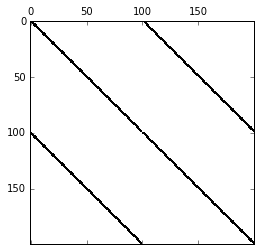

In [12]:
fig = plt.figure()
plt.spy(A[0:200,0:200])